In [1]:
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import linregress,norm
import tabix
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [2]:
pd.set_option('display.max_columns', None)


# Define gene order and plot and data directories

In [3]:
plots_dir = "./plots"
data_dir = "./data"

In [4]:
import sys
sys.path.append('../../')
from consensus_variables import *

# Load data

In [5]:
somatic_maf_df = pd.read_csv(somatic_maf_file, sep = "\t", header = 0)

maf_df_f = somatic_maf_df[~(somatic_maf_df['FILTER'].str.contains("not_in_exons"))].reset_index(drop = True)

/tmp/ipykernel_2043756/2123141286.py:1: DtypeWarning: Columns (49,92,112) have mixed types. Specify dtype option on import or set low_memory=False.
  somatic_maf_df = pd.read_csv(somatic_maf_file, sep = "\t", header = 0)


In [6]:
snvs_maf = maf_df_f[(maf_df_f['TYPE'] == 'SNV')
                    & (maf_df_f["canonical_CDS_position"] != '-')
                   ].reset_index(drop = True)
snvs_maf["canonical_CDS_position"] = snvs_maf["canonical_CDS_position"].astype(int)

### Omega

In [7]:
def fill_missing_positions_filtered(df):
    """
    Fills missing cDNA, CDS, and Protein positions with the closest non-missing value, considering only rows with non-missing values for the specific column.

    Args:
        df: A Pandas DataFrame with columns 'CHROM', 'POS', 'Consequence', 'cDNA_position', 'CDS_position', and 'Protein_position'.

    Returns:
        A Pandas DataFrame with additional columns 'closest_cDNA_position', 'closest_CDS_position', and 'closest_Protein_position'.
    """

    df_copy = df.copy()

    for col in ['canonical_cDNA_position', 'canonical_CDS_position', 'canonical_Protein_position']:
        df_copy[f'closest_{col}'] = df_copy[col].replace('-', pd.NA)
        missing_indices = df_copy.index[df_copy[f'closest_{col}'].isna()]
        
        for i in missing_indices:
            # Find the nearest non-missing value on either side
            prev_non_missing = df_copy.loc[:i, f'closest_{col}'].last_valid_index()
            next_non_missing = df_copy.loc[i:, f'closest_{col}'].first_valid_index()

            if prev_non_missing is not None and next_non_missing is not None:
                prev_pos_diff = abs(df_copy.loc[prev_non_missing, 'POS'] - df_copy.loc[i, 'POS'])
                next_pos_diff = abs(df_copy.loc[next_non_missing, 'POS'] - df_copy.loc[i, 'POS'])

                if prev_pos_diff < next_pos_diff:
                    df_copy.loc[i, f'closest_{col}'] = df_copy.loc[prev_non_missing, f'closest_{col}']
                else:
                    df_copy.loc[i, f'closest_{col}'] = df_copy.loc[next_non_missing, f'closest_{col}']
            elif prev_non_missing is not None:
                df_copy.loc[i, f'closest_{col}'] = df_copy.loc[prev_non_missing, f'closest_{col}']
            elif next_non_missing is not None:
                df_copy.loc[i, f'closest_{col}'] = df_copy.loc[next_non_missing, f'closest_{col}']

    return df_copy

In [8]:
# upd_snvs_maf = fill_missing_positions_filtered(snvs_maf)
# upd_snvs_maf['closest_canonical_cDNA_position'].astype(int)

Truncating

In [9]:
snvs_maf[snvs_maf["canonical_Consequence_broader"].isin(['nonsense',
                                                         "essential_splice"])]
# [
#     ['CHROM', 'POS', 'canonical_Consequence', 'canonical_cDNA_position', 'canonical_CDS_position', 'canonical_Protein_position',]].drop_duplicates().tail(50).reset_index(drop = True)

,CHROM,POS,REF,ALT,FILTER,INFO,FORMAT,SAMPLE,DEPTH,ALT_DEPTH,REF_DEPTH,VAF,vd_DEPTH,vd_ALT_DEPTH,vd_REF_DEPTH,vd_VAF,numNs,VAF_Ns,DEPTH_AM,ALT_DEPTH_AM,REF_DEPTH_AM,VAF_AM,numNs_AM,VAF_Ns_AM,DEPTH_ND,ALT_DEPTH_ND,VAF_ND,VAF_distorted_expanded,VAF_distorted_expanded_sq,VAF_distortion,VAF_distortion_sq,MUT_ID,SAMPLE_ID,METHOD,PROJECT_NAME,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT,DISTANCE,STRAND,FLAGS,SYMBOL,SYMBOL_SOURCE,HGNC_ID,CANONICAL,ENSP,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,CLIN_SIG,SOMATIC,PHENO,canonical_Location,canonical_Allele,canonical_Gene,canonical_Feature,canonical_Feature_type,canonical_Consequence,canonical_cDNA_position,canonical_CDS_position,canonical_Protein_position,canonical_Amino_acids,canonical_Codons,canonical_IMPACT,canonical_DISTANCE,canonical_STRAND,canonical_FLAGS,canonical_SYMBOL,canonical_SYMBOL_SOURCE,canonical_HGNC_ID,canonical_CANONICAL,canonical_ENSP,canonical_CLIN_SIG,canonical_Consequence_single,canonical_Consequence_broader,canonical_Protein_affecting,Consequence_single,Consequence_broader,Protein_affecting,CONTEXT_MUT,MUTTYPE,CONTEXT_MUT_SIGPRO,gnomAD_SNP,HOTSPOT_NAME,MUT_ID_pyr,CHROM_ensembl,POS_ensembl,REF_ensembl,ALT_ensembl,TYPE,INDEL_LENGTH,INDEL_INFRAME,INDEL_MULTIPLE3,N_rich_frequency,VAF_Ns_threshold,FILTER.cohort_n_rich_uni,FILTER.gnomAD_SNP,FILTER.not_covered,FILTER.not_in_exons,FILTER.p10,FILTER.pSTD,FILTER.repetitive_variant,FILTER.cohort_n_rich,FILTER.low_complex_repetitive,FILTER.LongMSI,FILTER.cohort_n_rich_threshold,FILTER.AM_no_pileup_support,FILTER.no_pileup_support,FILTER.n_rich,FILTER.other_sample_SNP,FILTER.PASS,FILTER.AM_not_searched_COMPLEX,FILTER.not_searched_COMPLEX,FILTER.MSI12,FILTER.AM_not_searched_SV,FILTER.not_searched_SV,FILTER.SN1.5,FILTER.q22.5,FILTER.v1,FILTER.low_mappability,FILTER.Bias,FILTER.d3
7,chr1,26729669,C,T,pSTD;repetitive_variant,SAMPLE=P19_0020_BDO_01;TYPE=SNV;DP=6467;VD=1;A...,GT:DP:VD:AD:AF:RD:ALD:CDP:CAD:NDP:CDPAM:CADAM:...,"0/1:6467:1:6466,1:0.0002:3943,2523:1,0:6469:64...",6469,1,6468,0.000155,6467,1,6466,0.000155,22,0.003389,11254,1,11253,0.000089,30,0.002659,4785,0,0.000000,False,False,0.574818,0.940644,chr1:26729669_C>T,P19_0020_BDO_01,med,NaN,chr1:26729669,T,ENSG00000117713,ENST00000324856,Transcript,stop_gained,1545,1156,386,Q/*,Cag/Tag,"rs2124784810,COSV61370777",HIGH,-,1,-,ARID1A,HGNC,HGNC:11110,YES,ENSP00000320485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-,"0,1","0,1",chr1:26729669,T,ENSG00000117713,ENST00000324856,Transcript,stop_gained,1545,1156,386,Q/*,Cag/Tag,HIGH,-,1.0,-,ARID1A,HGNC,HGNC:11110,YES,ENSP00000320485,-,stop_gained,nonsense,protein_affecting,stop_gained,nonsense,protein_affecting,TCA>T,C>T,T[C>T]A,False,-,chr1:26729669_C>T,1,26729669,C,T,SNV,0,False,False,0.0,1.1,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8,chr1,26729669,C,T,pSTD;repetitive_variant,SAMPLE=P19_0024_BDO_01;TYPE=SNV;DP=7764;VD=1;A...,GT:DP:VD:AD:AF:RD:ALD:CDP:CAD:NDP:CDPAM:CADAM:...,"0/1:7764:1:7763,1:0.0001:4406,3357:1,0:7768:77...",7768,1,7767,0.000129,7764,1,7763,0.000129,19,0.002440,11469,1,11468,0.000087,25,0.002175,3701,0,0.000000,False,False,0.677304,0.958316,chr1:26729669_C>T,P19_0024_BDO_01,med,NaN,chr1:26729669,T,ENSG00000117713,ENST00000324856,Transcript,stop_gained,1545,1156,386,Q/*,Cag/Tag,"rs2124784810,COSV61370777",HIGH,-,1,-,ARID1A,HGNC,HGNC:11110,YES,ENSP00000320485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-,"0,1","0,1",chr1:26729669,T,ENSG00000117713,ENST00000324856,Transcript,stop_gained,1545

In [10]:
# fill_missing_positions_filtered(dddd)

Synonymous

In [11]:
snvs_maf[snvs_maf["canonical_Consequence_broader"] == 'synonymous']

,CHROM,POS,REF,ALT,FILTER,INFO,FORMAT,SAMPLE,DEPTH,ALT_DEPTH,REF_DEPTH,VAF,vd_DEPTH,vd_ALT_DEPTH,vd_REF_DEPTH,vd_VAF,numNs,VAF_Ns,DEPTH_AM,ALT_DEPTH_AM,REF_DEPTH_AM,VAF_AM,numNs_AM,VAF_Ns_AM,DEPTH_ND,ALT_DEPTH_ND,VAF_ND,VAF_distorted_expanded,VAF_distorted_expanded_sq,VAF_distortion,VAF_distortion_sq,MUT_ID,SAMPLE_ID,METHOD,PROJECT_NAME,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT,DISTANCE,STRAND,FLAGS,SYMBOL,SYMBOL_SOURCE,HGNC_ID,CANONICAL,ENSP,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,CLIN_SIG,SOMATIC,PHENO,canonical_Location,canonical_Allele,canonical_Gene,canonical_Feature,canonical_Feature_type,canonical_Consequence,canonical_cDNA_position,canonical_CDS_position,canonical_Protein_position,canonical_Amino_acids,canonical_Codons,canonical_IMPACT,canonical_DISTANCE,canonical_STRAND,canonical_FLAGS,canonical_SYMBOL,canonical_SYMBOL_SOURCE,canonical_HGNC_ID,canonical_CANONICAL,canonical_ENSP,canonical_CLIN_SIG,canonical_Consequence_single,canonical_Consequence_broader,canonical_Protein_affecting,Consequence_single,Consequence_broader,Protein_affecting,CONTEXT_MUT,MUTTYPE,CONTEXT_MUT_SIGPRO,gnomAD_SNP,HOTSPOT_NAME,MUT_ID_pyr,CHROM_ensembl,POS_ensembl,REF_ensembl,ALT_ensembl,TYPE,INDEL_LENGTH,INDEL_INFRAME,INDEL_MULTIPLE3,N_rich_frequency,VAF_Ns_threshold,FILTER.cohort_n_rich_uni,FILTER.gnomAD_SNP,FILTER.not_covered,FILTER.not_in_exons,FILTER.p10,FILTER.pSTD,FILTER.repetitive_variant,FILTER.cohort_n_rich,FILTER.low_complex_repetitive,FILTER.LongMSI,FILTER.cohort_n_rich_threshold,FILTER.AM_no_pileup_support,FILTER.no_pileup_support,FILTER.n_rich,FILTER.other_sample_SNP,FILTER.PASS,FILTER.AM_not_searched_COMPLEX,FILTER.not_searched_COMPLEX,FILTER.MSI12,FILTER.AM_not_searched_SV,FILTER.not_searched_SV,FILTER.SN1.5,FILTER.q22.5,FILTER.v1,FILTER.low_mappability,FILTER.Bias,FILTER.d3
31,chr1,26729692,G,A,pSTD,SAMPLE=P19_0009_BTR_01;TYPE=SNV;DP=5730;VD=1;A...,GT:DP:VD:AD:AF:RD:ALD:CDP:CAD:NDP:CDPAM:CADAM:...,"0/1:5730:1:5729,1:0.0002:3059,2670:0,1:5733:57...",5733,1,5732,0.000174,5730,1,5729,0.000175,22,0.003823,9764,1,9763,0.000102,25,0.002554,4031,0,0.0,False,False,0.587157,0.942038,chr1:26729692_G>A,P19_0009_BTR_01,med,NaN,chr1:26729692,A,ENSG00000117713,ENST00000324856,Transcript,synonymous_variant,1568,1179,393,Q,caG/caA,rs2124784918,LOW,-,1,-,ARID1A,HGNC,HGNC:11110,YES,ENSP00000320485,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,-,-,-,chr1:26729692,A,ENSG00000117713,ENST00000324856,Transcript,synonymous_variant,1568,1179,393,Q,caG/caA,LOW,-,1.0,-,ARID1A,HGNC,HGNC:11110,YES,ENSP00000320485,-,synonymous_variant,synonymous,non_protein_affecting,synonymous_variant,synonymous,non_protein_affecting,GCT>T,C>T,G[C>T]T,False,-,chr1:26729692_C>T,1,26729692,G,A,SNV,0,False,False,0.0,1.1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
35,chr1,26729704,G,C,pSTD,SAMPLE=P19_0008_BDO_01;TYPE=SNV;DP=6414;VD=1;A...,GT:DP:VD:AD:AF:RD:ALD:CDP:CAD:NDP:CDPAM:CADAM:...,"0/1:6414:1:6413,1:0.0002:3714,2699:1,0:6414:64...",6414,1,6413,0.000156,6414,1,6413,0.000156,12,0.001867,11681,1,11680,0.000086,17,0.001453,5267,0,0.0,False,False,0.549097,0.935992,chr1:26729704_G>C,P19_0008_BDO_01,med,NaN,chr1:26729704,C,ENSG00000117713,ENST00000324856,Transcript,synonymous_variant,1580,1191,397,G,ggG/ggC,rs1191450683,LOW,-,1,-,ARID1A,HGNC,HGNC:11110,YES,ENSP00000320485,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,-,-,-,chr1:26729704,C,ENSG00000117713,ENST00000324856,Transcript,synonymous_

______

Missense

In [12]:
snvs_maf[snvs_maf["canonical_Consequence_broader"] == 'missense']

,CHROM,POS,REF,ALT,FILTER,INFO,FORMAT,SAMPLE,DEPTH,ALT_DEPTH,REF_DEPTH,VAF,vd_DEPTH,vd_ALT_DEPTH,vd_REF_DEPTH,vd_VAF,numNs,VAF_Ns,DEPTH_AM,ALT_DEPTH_AM,REF_DEPTH_AM,VAF_AM,numNs_AM,VAF_Ns_AM,DEPTH_ND,ALT_DEPTH_ND,VAF_ND,VAF_distorted_expanded,VAF_distorted_expanded_sq,VAF_distortion,VAF_distortion_sq,MUT_ID,SAMPLE_ID,METHOD,PROJECT_NAME,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT,DISTANCE,STRAND,FLAGS,SYMBOL,SYMBOL_SOURCE,HGNC_ID,CANONICAL,ENSP,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,CLIN_SIG,SOMATIC,PHENO,canonical_Location,canonical_Allele,canonical_Gene,canonical_Feature,canonical_Feature_type,canonical_Consequence,canonical_cDNA_position,canonical_CDS_position,canonical_Protein_position,canonical_Amino_acids,canonical_Codons,canonical_IMPACT,canonical_DISTANCE,canonical_STRAND,canonical_FLAGS,canonical_SYMBOL,canonical_SYMBOL_SOURCE,canonical_HGNC_ID,canonical_CANONICAL,canonical_ENSP,canonical_CLIN_SIG,canonical_Consequence_single,canonical_Consequence_broader,canonical_Protein_affecting,Consequence_single,Consequence_broader,Protein_affecting,CONTEXT_MUT,MUTTYPE,CONTEXT_MUT_SIGPRO,gnomAD_SNP,HOTSPOT_NAME,MUT_ID_pyr,CHROM_ensembl,POS_ensembl,REF_ensembl,ALT_ensembl,TYPE,INDEL_LENGTH,INDEL_INFRAME,INDEL_MULTIPLE3,N_rich_frequency,VAF_Ns_threshold,FILTER.cohort_n_rich_uni,FILTER.gnomAD_SNP,FILTER.not_covered,FILTER.not_in_exons,FILTER.p10,FILTER.pSTD,FILTER.repetitive_variant,FILTER.cohort_n_rich,FILTER.low_complex_repetitive,FILTER.LongMSI,FILTER.cohort_n_rich_threshold,FILTER.AM_no_pileup_support,FILTER.no_pileup_support,FILTER.n_rich,FILTER.other_sample_SNP,FILTER.PASS,FILTER.AM_not_searched_COMPLEX,FILTER.not_searched_COMPLEX,FILTER.MSI12,FILTER.AM_not_searched_SV,FILTER.not_searched_SV,FILTER.SN1.5,FILTER.q22.5,FILTER.v1,FILTER.low_mappability,FILTER.Bias,FILTER.d3
0,chr1,26729654,T,C,pSTD,SAMPLE=P19_0038_BDO_01;TYPE=SNV;DP=6080;VD=1;A...,GT:DP:VD:AD:AF:RD:ALD:CDP:CAD:NDP:CDPAM:CADAM:...,"0/1:6080:1:6079,1:0.0002:4345,1734:1,0:6082:60...",6082,1,6081,0.000164,6080,1,6079,0.000164,27,0.004420,13495,1,13494,0.000074,42,0.003103,7413,0,0.0,False,False,0.450685,0.916196,chr1:26729654_T>C,P19_0038_BDO_01,med,NaN,chr1:26729654,C,ENSG00000117713,ENST00000324856,Transcript,missense_variant,1530,1141,381,S/P,Tcc/Ccc,COSV61375919,MODERATE,-,1,-,ARID1A,HGNC,HGNC:11110,YES,ENSP00000320485,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-,1,1,chr1:26729654,C,ENSG00000117713,ENST00000324856,Transcript,missense_variant,1530,1141,381,S/P,Tcc/Ccc,MODERATE,-,1.0,-,ARID1A,HGNC,HGNC:11110,YES,ENSP00000320485,-,missense_variant,missense,protein_affecting,missense_variant,missense,protein_affecting,ATC>C,T>C,A[T>C]C,False,-,chr1:26729654_T>C,1,26729654,T,C,SNV,0,False,False,0.0,1.1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,chr1,26729655,C,G,pSTD,SAMPLE=P19_0051_BTR_01;TYPE=SNV;DP=9195;VD=1;A...,GT:DP:VD:AD:AF:RD:ALD:CDP:CAD:NDP:CDPAM:CADAM:...,"0/1:9195:1:9194,1:0.0001:6295,2899:1,0:9195:91...",9195,1,9194,0.000109,9195,1,9194,0.000109,40,0.004331,19756,1,19754,0.000051,60,0.003028,10561,0,0.0,False,False,0.465428,0.922679,chr1:26729655_C>G,P19_0051_BTR_01,med,NaN,chr1:26729655,G,ENSG00000117713,ENST00000324856,Transcript,missense_variant,1531,1142,381,S/C,tCc/tGc,"rs1557591022,COSV61385429",MODERATE,-,1,-,ARID1A,HGNC,HGNC:11110,YES,ENSP00000320485,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-,"0,1","0,1",chr1:26729655,G,ENSG00000117713,ENST00000324856,Transcript,missense_variant,1531,1142,3

### OncodriveFML

#### Load gene/protein regions information

In [13]:
seq_regions_df = pd.read_table("/data/bbg/nobackup/scratch/oncodrive3d/datasets_240506/seq_for_mut_prob.tsv")

In [14]:
tb = tabix.open("/data/bbg/datasets/CADD/v1.7/hg38/whole_genome_SNVs.tsv.gz")

#### Query scores of each gene

In [15]:
def get_scores_gene(gene_info):
    chromosome = gene_info["Chr"].values[0]
    reverse_strand = gene_info["Reverse_strand"].values[0] == 1
    exon_coords = eval(gene_info["Exons_coord"].values[0])
    if reverse_strand:
        exon_coords = [(y, x) for x, y in exon_coords]


    position_mutation = dict()
    for start, stop in exon_coords:
        for e in tb.query(str(chromosome), start, stop):
            if int(e[1]) not in position_mutation:
                position_mutation[int(e[1])] = dict()
            position_mutation[int(e[1])][e[3]] = float(e[5])
            
    start2end_coords = { x:y for x, y in enumerate(sorted(position_mutation.keys(), reverse = not reverse_strand))}

    return position_mutation, start2end_coords

#### Scores of observed mutations

In [16]:
def score_mutations_from_gene(snv_data):
    scores_muts = []
    for ind, row in snv_data.iterrows():
        try:
            scores_muts.append(scores_all_mutations_in_gene[row["POS"]].get(row["ALT"], 0))
            print("found")
        except:
            scores_muts.append(0)
            print(row["Consequence"], "not found")
    snv_data["CADDscore"] = scores_muts
    return snv_data
    

In [17]:
for gene in ["TP53"]:
# for gene in gene_order:
    gene_info = seq_regions_df[seq_regions_df["Gene"] == gene]
    scores_all_mutations_in_gene, scores_of_protein_position = get_scores_gene(gene_info)
    
    mutations_in_gene = snvs_maf[snvs_maf["canonical_SYMBOL"] == gene].copy()
    scored_mutations_in_gene = score_mutations_from_gene(mutations_in_gene)
    
    scored_mutations_in_gene.to_csv(f"{data_dir}/mutations_scored.{gene}.tsv", sep = '\t', header= True, index = False)

stop_lost not found
stop_lost not found
stop_lost not found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
splice_region_variant,synonymous_variant not found
found
found
found
found
found
found
found
found
found
found
found
found
missense_variant,splice_region_variant not found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found


___

### Indels

In [18]:
# filter and somatic only
indel_maf_df = maf_df_f.loc[
                        (maf_df_f["TYPE"].isin(["INSERTION", "DELETION"]))
                        ].reset_index(drop = True)
indel_maf_df

,CHROM,POS,REF,ALT,FILTER,INFO,FORMAT,SAMPLE,DEPTH,ALT_DEPTH,REF_DEPTH,VAF,vd_DEPTH,vd_ALT_DEPTH,vd_REF_DEPTH,vd_VAF,numNs,VAF_Ns,DEPTH_AM,ALT_DEPTH_AM,REF_DEPTH_AM,VAF_AM,numNs_AM,VAF_Ns_AM,DEPTH_ND,ALT_DEPTH_ND,VAF_ND,VAF_distorted_expanded,VAF_distorted_expanded_sq,VAF_distortion,VAF_distortion_sq,MUT_ID,SAMPLE_ID,METHOD,PROJECT_NAME,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT,DISTANCE,STRAND,FLAGS,SYMBOL,SYMBOL_SOURCE,HGNC_ID,CANONICAL,ENSP,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,CLIN_SIG,SOMATIC,PHENO,canonical_Location,canonical_Allele,canonical_Gene,canonical_Feature,canonical_Feature_type,canonical_Consequence,canonical_cDNA_position,canonical_CDS_position,canonical_Protein_position,canonical_Amino_acids,canonical_Codons,canonical_IMPACT,canonical_DISTANCE,canonical_STRAND,canonical_FLAGS,canonical_SYMBOL,canonical_SYMBOL_SOURCE,canonical_HGNC_ID,canonical_CANONICAL,canonical_ENSP,canonical_CLIN_SIG,canonical_Consequence_single,canonical_Consequence_broader,canonical_Protein_affecting,Consequence_single,Consequence_broader,Protein_affecting,CONTEXT_MUT,MUTTYPE,CONTEXT_MUT_SIGPRO,gnomAD_SNP,HOTSPOT_NAME,MUT_ID_pyr,CHROM_ensembl,POS_ensembl,REF_ensembl,ALT_ensembl,TYPE,INDEL_LENGTH,INDEL_INFRAME,INDEL_MULTIPLE3,N_rich_frequency,VAF_Ns_threshold,FILTER.cohort_n_rich_uni,FILTER.gnomAD_SNP,FILTER.not_covered,FILTER.not_in_exons,FILTER.p10,FILTER.pSTD,FILTER.repetitive_variant,FILTER.cohort_n_rich,FILTER.low_complex_repetitive,FILTER.LongMSI,FILTER.cohort_n_rich_threshold,FILTER.AM_no_pileup_support,FILTER.no_pileup_support,FILTER.n_rich,FILTER.other_sample_SNP,FILTER.PASS,FILTER.AM_not_searched_COMPLEX,FILTER.not_searched_COMPLEX,FILTER.MSI12,FILTER.AM_not_searched_SV,FILTER.not_searched_SV,FILTER.SN1.5,FILTER.q22.5,FILTER.v1,FILTER.low_mappability,FILTER.Bias,FILTER.d3
0,chr1,26729645,TTG,T,pSTD,SAMPLE=P19_0024_BDO_01;TYPE=Deletion;DP=7803;V...,GT:DP:VD:AD:AF:RD:ALD:CDP:CAD:NDP:CDPAM:CADAM:...,"0/1:7803:1:7802,1:0.0001:4759,3043:1,0:7769:77...",7769,1,7768,0.000129,7803,1,7802,0.000128,17,0.002183,11749,1,11748,0.000085,24,0.002039,3980,0,0.000000,False,False,0.661248,0.955863,chr1:26729645_TTG>T,P19_0024_BDO_01,med,NaN,chr1:26729646-26729647,-,ENSG00000117713,ENST00000324856,Transcript,"splice_region_variant,splice_polypyrimidine_tr...",-,-,-,-,-,rs1422289765,LOW,-,1,-,ARID1A,HGNC,HGNC:11110,YES,ENSP00000320485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-,-,-,chr1:26729646-26729647,-,ENSG00000117713,ENST00000324856,Transcript,"splice_region_variant,splice_polypyrimidine_tr...",-,-,-,-,-,LOW,-,1.0,-,ARID1A,HGNC,HGNC:11110,YES,ENSP00000320485,-,splice_region_variant,splice_region_variant,ambiguous,splice_region_variant,splice_region_variant,ambiguous,-,-,-,False,-,chr1:26729645_TTG>T,1,26729646,TG,-,DELETION,2,False,False,0.0,1.1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,chr1,26729650,GCCAT,G,pSTD,SAMPLE=P19_0046_BTR_01;TYPE=Deletion;DP=5868;V...,GT:DP:VD:AD:AF:RD:ALD:CDP:CAD:NDP:CDPAM:CADAM:...,"0/1:5868:1:5867,1:0.0002:3185,2682:1,0:5879:58...",5879,1,5878,0.000170,5868,1,5867,0.000170,23,0.003897,11107,1,11106,0.000090,26,0.002335,5228,0,0.000000,False,False,0.529306,0.931705,chr1:26729650_GCCAT>G,P19_0046_BTR_01,med,NaN,chr1:26729651-26729654,-,ENSG00000117713,ENST00000324856,Transcript,"frameshift_variant,splice_region_variant",1527-1530,1138-1141,380-381,PS/X,CCATcc/cc,-,HIGH,-,1,-,ARID1A,HGNC,HGNC:11110,YES,ENSP00000320485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-,-,-,chr1:26729

Observed frameshift indels + inframes of length >= 5 AA

In [19]:
frameshift_indels = indel_maf_df[(~indel_maf_df["INDEL_INFRAME"]) &
                                 (indel_maf_df["canonical_CDS_position"] != '-' )].reset_index(drop = True)
frameshift_indels[frameshift_indels["canonical_SYMBOL"] == "TP53"]

,CHROM,POS,REF,ALT,FILTER,INFO,FORMAT,SAMPLE,DEPTH,ALT_DEPTH,REF_DEPTH,VAF,vd_DEPTH,vd_ALT_DEPTH,vd_REF_DEPTH,vd_VAF,numNs,VAF_Ns,DEPTH_AM,ALT_DEPTH_AM,REF_DEPTH_AM,VAF_AM,numNs_AM,VAF_Ns_AM,DEPTH_ND,ALT_DEPTH_ND,VAF_ND,VAF_distorted_expanded,VAF_distorted_expanded_sq,VAF_distortion,VAF_distortion_sq,MUT_ID,SAMPLE_ID,METHOD,PROJECT_NAME,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT,DISTANCE,STRAND,FLAGS,SYMBOL,SYMBOL_SOURCE,HGNC_ID,CANONICAL,ENSP,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,CLIN_SIG,SOMATIC,PHENO,canonical_Location,canonical_Allele,canonical_Gene,canonical_Feature,canonical_Feature_type,canonical_Consequence,canonical_cDNA_position,canonical_CDS_position,canonical_Protein_position,canonical_Amino_acids,canonical_Codons,canonical_IMPACT,canonical_DISTANCE,canonical_STRAND,canonical_FLAGS,canonical_SYMBOL,canonical_SYMBOL_SOURCE,canonical_HGNC_ID,canonical_CANONICAL,canonical_ENSP,canonical_CLIN_SIG,canonical_Consequence_single,canonical_Consequence_broader,canonical_Protein_affecting,Consequence_single,Consequence_broader,Protein_affecting,CONTEXT_MUT,MUTTYPE,CONTEXT_MUT_SIGPRO,gnomAD_SNP,HOTSPOT_NAME,MUT_ID_pyr,CHROM_ensembl,POS_ensembl,REF_ensembl,ALT_ensembl,TYPE,INDEL_LENGTH,INDEL_INFRAME,INDEL_MULTIPLE3,N_rich_frequency,VAF_Ns_threshold,FILTER.cohort_n_rich_uni,FILTER.gnomAD_SNP,FILTER.not_covered,FILTER.not_in_exons,FILTER.p10,FILTER.pSTD,FILTER.repetitive_variant,FILTER.cohort_n_rich,FILTER.low_complex_repetitive,FILTER.LongMSI,FILTER.cohort_n_rich_threshold,FILTER.AM_no_pileup_support,FILTER.no_pileup_support,FILTER.n_rich,FILTER.other_sample_SNP,FILTER.PASS,FILTER.AM_not_searched_COMPLEX,FILTER.not_searched_COMPLEX,FILTER.MSI12,FILTER.AM_not_searched_SV,FILTER.not_searched_SV,FILTER.SN1.5,FILTER.q22.5,FILTER.v1,FILTER.low_mappability,FILTER.Bias,FILTER.d3
8909,chr17,7669611,AGTCT,A,pSTD,SAMPLE=P19_0009_BDO_01;TYPE=Deletion;DP=3873;V...,GT:DP:VD:AD:AF:RD:ALD:CDP:CAD:NDP:CDPAM:CADAM:...,"0/1:3873:1:3872,1:0.0003:2741,1131:1,0:3829:38...",3829,1,3828,0.000261,3873,1,3872,0.000258,24,0.006229,7842,1,7841,0.000128,27,0.003431,4013,0,0.000000,False,False,0.488268,0.920055,chr17:7669611_AGTCT>A,P19_0009_BDO_01,med,NaN,chr17:7669612-7669615,-,ENSG00000141510,ENST00000269305,Transcript,frameshift_variant,1318-1321,1176-1179,392-393,SD/X,tcAGAC/tc,-,HIGH,-,-1,-,TP53,HGNC,HGNC:11998,YES,ENSP00000269305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-,-,-,chr17:7669612-7669615,-,ENSG00000141510,ENST00000269305,Transcript,frameshift_variant,1318-1321,1176-1179,392-393,SD/X,tcAGAC/tc,HIGH,-,-1.0,-,TP53,HGNC,HGNC:11998,YES,ENSP00000269305,-,frameshift_variant,nonsense,protein_affecting,frameshift_variant,nonsense,protein_affecting,-,-,-,False,-,chr17:7669611_AGTCT>A,17,7669612,GTCT,-,DELETION,4,False,False,0.0,1.1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8910,chr17,7669612,GTC,G,pSTD,SAMPLE=P19_0048_BTR_01;TYPE=Deletion;DP=4416;V...,GT:DP:VD:AD:AF:RD:ALD:CDP:CAD:NDP:CDPAM:CADAM:...,"0/1:4416:1:4415,1:0.0002:2387,2028:1,0:4434:44...",4434,1,4433,0.000226,4416,1,4415,0.000226,13,0.002923,6854,1,6853,0.000146,8,0.001166,2420,0,0.000000,False,False,0.646922,0.950691,chr17:7669612_GTC>G,P19_0048_BTR_01,med,NaN,chr17:7669613-7669614,-,ENSG00000141510,ENST00000269305,Transcript,frameshift_variant,1319-1320,1177-1178,393,D/X,GAc/c,-,HIGH,-,-1,-,TP53,HGNC,HGNC:11998,YES,ENSP00000269305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-,-,-,chr17:7669613-7669614,-,ENSG00000141510,ENST00000269305,Transcript,fr

___

Inframe indels

In [20]:
inframe_indels = indel_maf_df[(indel_maf_df["INDEL_INFRAME"]) &
                              (indel_maf_df["canonical_CDS_position"] != '-' )].reset_index(drop = True)
inframe_indels[inframe_indels["canonical_SYMBOL"] == "TP53"]

,CHROM,POS,REF,ALT,FILTER,INFO,FORMAT,SAMPLE,DEPTH,ALT_DEPTH,REF_DEPTH,VAF,vd_DEPTH,vd_ALT_DEPTH,vd_REF_DEPTH,vd_VAF,numNs,VAF_Ns,DEPTH_AM,ALT_DEPTH_AM,REF_DEPTH_AM,VAF_AM,numNs_AM,VAF_Ns_AM,DEPTH_ND,ALT_DEPTH_ND,VAF_ND,VAF_distorted_expanded,VAF_distorted_expanded_sq,VAF_distortion,VAF_distortion_sq,MUT_ID,SAMPLE_ID,METHOD,PROJECT_NAME,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT,DISTANCE,STRAND,FLAGS,SYMBOL,SYMBOL_SOURCE,HGNC_ID,CANONICAL,ENSP,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,CLIN_SIG,SOMATIC,PHENO,canonical_Location,canonical_Allele,canonical_Gene,canonical_Feature,canonical_Feature_type,canonical_Consequence,canonical_cDNA_position,canonical_CDS_position,canonical_Protein_position,canonical_Amino_acids,canonical_Codons,canonical_IMPACT,canonical_DISTANCE,canonical_STRAND,canonical_FLAGS,canonical_SYMBOL,canonical_SYMBOL_SOURCE,canonical_HGNC_ID,canonical_CANONICAL,canonical_ENSP,canonical_CLIN_SIG,canonical_Consequence_single,canonical_Consequence_broader,canonical_Protein_affecting,Consequence_single,Consequence_broader,Protein_affecting,CONTEXT_MUT,MUTTYPE,CONTEXT_MUT_SIGPRO,gnomAD_SNP,HOTSPOT_NAME,MUT_ID_pyr,CHROM_ensembl,POS_ensembl,REF_ensembl,ALT_ensembl,TYPE,INDEL_LENGTH,INDEL_INFRAME,INDEL_MULTIPLE3,N_rich_frequency,VAF_Ns_threshold,FILTER.cohort_n_rich_uni,FILTER.gnomAD_SNP,FILTER.not_covered,FILTER.not_in_exons,FILTER.p10,FILTER.pSTD,FILTER.repetitive_variant,FILTER.cohort_n_rich,FILTER.low_complex_repetitive,FILTER.LongMSI,FILTER.cohort_n_rich_threshold,FILTER.AM_no_pileup_support,FILTER.no_pileup_support,FILTER.n_rich,FILTER.other_sample_SNP,FILTER.PASS,FILTER.AM_not_searched_COMPLEX,FILTER.not_searched_COMPLEX,FILTER.MSI12,FILTER.AM_not_searched_SV,FILTER.not_searched_SV,FILTER.SN1.5,FILTER.q22.5,FILTER.v1,FILTER.low_mappability,FILTER.Bias,FILTER.d3
759,chr17,7669639,CATG,C,p10;pSTD,SAMPLE=P19_0034_BDO_01;TYPE=Deletion;DP=4948;V...,GT:DP:VD:AD:AF:RD:ALD:CDP:CAD:NDP:CDPAM:CADAM:...,"0/1:4948:1:4947,1:0.0002:2970,1977:0,1:4930:49...",4930,1,4929,0.000203,4948,1,4947,0.000202,11,0.002226,8144,1,8143,0.000123,15,0.001838,3214,0,0.0,False,False,0.605354,0.944260,chr17:7669639_CATG>C,P19_0034_BDO_01,med,NaN,chr17:7669640-7669642,-,ENSG00000141510,ENST00000269305,Transcript,inframe_deletion,1291-1293,1149-1151,383-384,LM/L,ctCATg/ctg,-,MODERATE,-,-1,-,TP53,HGNC,HGNC:11998,YES,ENSP00000269305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-,-,-,chr17:7669640-7669642,-,ENSG00000141510,ENST00000269305,Transcript,inframe_deletion,1291-1293,1149-1151,383-384,LM/L,ctCATg/ctg,MODERATE,-,-1.0,-,TP53,HGNC,HGNC:11998,YES,ENSP00000269305,-,inframe_deletion,missense,protein_affecting,inframe_deletion,missense,protein_affecting,-,-,-,False,-,chr17:7669639_CATG>C,17,7669640,ATG,-,DELETION,3,True,False,0.0,1.1,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
760,chr17,7673832,TTAC,T,pSTD,SAMPLE=P19_0004_BTR_01;TYPE=Deletion;DP=10396;...,GT:DP:VD:AD:AF:RD:ALD:CDP:CAD:NDP:CDPAM:CADAM:...,"0/1:10396:1:10395,1:0.0001:4223,6172:1,0:10454...",10454,1,10453,0.000096,10396,1,10395,0.000096,35,0.003337,27268,1,27267,0.000037,85,0.003108,16814,0,0.0,False,False,0.383380,0.906131,chr17:7673832_TTAC>T,P19_0004_BTR_01,med,NaN,chr17:7673833-7673835,-,ENSG00000141510,ENST00000269305,Transcript,"inframe_deletion,splice_region_variant",927-929,785-787,262-263,GN/D,gGTAat/gat,-,MODERATE,-,-1,-,TP53,HGNC,HGNC:11998,YES,ENSP00000269305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-,-,-,chr17:7673833-7673835,-,ENSG00000141510

# __SIDE FIGURES__

In [21]:
def generate_all_side_figures(sample, 
                              run_dir,
                              gene_list = None,
                              store_plots_dir = None,
                              tools = ["oncodrivefml", "oncodrive3d", "omega_trunc", "omega_mis", "excess_indels"]):
    possible_genes = []
    if "oncodrivefml" in tools:
        oncodrivefml_data = pd.read_table(f"{run_dir}/oncodrivefmlsnvs/{sample}.all/{sample}-oncodrivefml.tsv.gz")
        oncodrivefml_data = oncodrivefml_data[["GENE_ID", "Z-SCORE", "Q_VALUE", "AVG_SCORE_OBS", "POPULATION_MEAN", "STD_OF_MEANS"]]
        oncodrivefml_data.columns = ["GENE", "OncodriveFML", "pvalue", "OBSERVED_MEAN", "BACKGROUND_MEAN", "BACKGROUND_STD"]
        possible_genes += list(pd.unique(oncodrivefml_data["GENE"]))


    if "omega_trunc" in tools or "omega_mis" in tools:
        omega_data = pd.read_table(f"{run_dir}/omega/output_mle.{sample}.tsv")
        omega_data = omega_data[omega_data["impact"].isin(['missense', 'truncating'])]
        if "omega_trunc" in tools :
            omega_truncating = omega_data[omega_data["impact"] == "truncating"].reset_index(drop = True)[["gene", "dnds", "pvalue", "lower", "upper"]]
            omega_truncating.columns = ["GENE", "omega_trunc", "pvalue", "lower", "upper"]
            possible_genes += list(pd.unique(omega_truncating["GENE"]))
            
        if "omega_mis" in tools :
            omega_missense = omega_data[omega_data["impact"] == "missense"].reset_index(drop = True)[["gene", "dnds", "pvalue", "lower", "upper"]]
            omega_missense.columns = ["GENE", "omega_mis", "pvalue", "lower", "upper"]
            possible_genes += list(pd.unique(omega_missense["GENE"]))

            
    if "excess_indels" in tools:
        indels_data = pd.read_table(f"{deepcsa_run_dir}/indels/{sample}.sample.indels.tsv",
                                    sep = '\t',
                                    header = 0)
   
    if gene_list is not None:
        gene_list = list(set(gene_list))
    else:
        # gene_list = list(pd.unique(oncodrivefml_data["GENE"]))
        gene_list = list(set(possible_genes))
        


    for genee in gene_list:
        print(genee)
        
        if "oncodrivefml" in tools:
            # Select the specific gene data
            oncodrivefml_gene_data = oncodrivefml_data[oncodrivefml_data["GENE"] == genee].to_dict(orient='records')[0]
            fig_gene_fml = plot_oncodrivefml_side(oncodrivefml_gene_data)
    
            if store_plots_dir is not None:
                fig_gene_fml.savefig(f"{store_plots_dir}/{genee}.oncodrivefml_side.png", bbox_inches='tight')
            plt.show()
            plt.close()
        
        if "omega_trunc" in tools or "omega_mis" in tools:
            omega_df = build_counts_from_df_complete(genee, snvs_maf, omega_truncating, omega_missense)
            
            fig_gene_omega = plot_omega_side_complete(omega_df)
            if store_plots_dir is not None:
                fig_gene_omega.savefig(f"{store_plots_dir}/{genee}.omega_side.png", bbox_inches='tight')
            plt.show()
            plt.close()
        
        
        if "excess_indels" in tools:
            indel_data_gene = indels_data[indels_data["SYMBOL"] == genee].to_dict(orient='records')[0]
            fig_gene_indel = plotting_indels_side(indel_data_gene)
            if store_plots_dir is not None:
                fig_gene_indel.savefig(f"{store_plots_dir}/{genee}.indels_side.png", bbox_inches='tight')
            plt.show()
            plt.close()
        
        
        print("\n\n\n")
        # break

### Omega missense and truncating

In [22]:
def build_counts_from_df_complete(genee, snvs_maf, omega_truncating, omega_missense):

    trunc_omega = float(omega_truncating[omega_truncating["GENE"] == genee]["omega_trunc"].values[0])
    trunc_pvalue = float(omega_truncating[omega_truncating["GENE"] == genee]["pvalue"].values[0])

    miss_omega = float(omega_missense[omega_missense["GENE"] == genee]["omega_mis"].values[0])
    miss_pvalue = float(omega_missense[omega_missense["GENE"] == genee]["pvalue"].values[0])
    snvs_gene = snvs_maf[snvs_maf["SYMBOL"] == genee].reset_index(drop = True)


    # Calculate counts based on canonical consequences
    truncating_count = snvs_gene[snvs_gene["canonical_Consequence_broader"].isin(['nonsense', "essential_splice"])].shape[0]
    missense_count = snvs_gene[snvs_gene["canonical_Consequence_broader"].isin(['missense'])].shape[0]
    synonymous_count = snvs_gene[snvs_gene["canonical_Consequence_broader"].isin(["synonymous"])].shape[0]

    # Compute 
    expected_missense = (1 - ((miss_omega - 1) / miss_omega)) * missense_count
    expected_truncating = (1 - ((trunc_omega - 1) / trunc_omega)) * truncating_count


    # Create a dataframe from the counts and expected values
    data = {
        'type': ['truncating', 'synonymous', 'missense'],
        'number_obs': [truncating_count, synonymous_count, missense_count],
        'expected': [expected_truncating, None, expected_missense],
        'omega': [trunc_omega, None, miss_omega],
        'pvalue': [trunc_pvalue, None, miss_pvalue]
    }
    df = pd.DataFrame(data)

    # Print the final dataframe
    return df


In [23]:
def plot_omega_side_complete(df):

    consequence_order = ['truncating', "synonymous", "missense"]

    # Define colors for each type
    colors = {
        'truncating': metrics_colors_dictionary["omega_trunc"],
        'missense': metrics_colors_dictionary["omega_miss"],
        'synonymous': metrics_colors_dictionary["omega_synon"]
    }
    
    t_omega = df[df['type'] == 'truncating']['omega'].item()
    t_pvalue = df[df['type'] == 'truncating']['pvalue'].item()
    m_omega = df[df['type'] == 'missense']['omega'].item()
    m_pvalue = df[df['type'] == 'missense']['pvalue'].item()
    
    
    # Plot for truncating, missense, and synonymous
    fig, ax = plt.subplots(figsize=(4, 2))

#     # Bar positions
#     y_positions = np.arange(len(consequence_order)) * 2  # Add separation between bars

#     # Plot the observed values as filled bars
#     for i, cons in enumerate(consequence_order):
#         obs_value = df[df['type'] == cons]['number_obs'].values[0]
#         ax.barh(y_positions[i], obs_value, color=colors[cons], label=cons)

    # Plot the observed values as filled bars
    sns.barplot(data=df, y='type', x='number_obs',
                hue = 'type', legend = False,
                hue_order = consequence_order,
                order=consequence_order, palette=[colors[x] for x in consequence_order],
                ax = ax
                )

    # Overlay the expected values with shaded portions
    leg = True
    for i, row in df.iterrows():
        if row['expected'] is not None:
            # plt.barh(row['type'], row['expected'], color='gray', alpha=0.5, edgecolor='none')
            # plt.barh(row['type'], row['expected'], color='none', edgecolor=colors[row['type']], hatch='//', linewidth=0)
            if leg:
                ax.barh(row['type'], row['expected'], color='none', edgecolor="gray", hatch='////', linewidth=0, label = 'expected')
                leg = False
            else:
                ax.barh(row['type'], row['expected'], color='none', edgecolor="gray", hatch='////', linewidth=0)



    # Remove the right and top spines
    # ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Customize the ticks and labels
    ax.xaxis.set_ticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])


    # Text annotations
    text_separation = max(df['number_obs']) * 0.03
    deviation_for_centering = text_separation * 12
    
    # text_of_line_separation = line_separation / 3
    text_pos1 = max(df[df['type'].isin(consequence_order[:2])]['number_obs']) + text_separation + deviation_for_centering
    text_pos2 = max(df[df['type'].isin(consequence_order[1:])]['number_obs']) + text_separation + deviation_for_centering
    # print(text_pos1, text_pos2)
    
    ax.text(text_pos1, 0.05,
            # r'$\omega_{trunc}$ = ' + f"{t_omega:.2f}",
            r'$dN/dS_{trunc}$ = ' + f"{t_omega:.2f}",
            # transform=ax.transAxes,
            fontsize=13, ha='center', va='bottom',
            color=colors['truncating'])
                   #f'$p$-value = {p_value:.2g}')

    ax.text(text_pos1, 0.45, f'$p$-value < {max(t_pvalue, 1e-6):.1e}',
            # transform=ax.transAxes,
            fontsize=12, ha='center', va='bottom',
            color=colors['truncating'])

    ax.text(text_pos2, 1.95,
            # r'$\omega_{mis}$ = ' + f"{m_omega:.2f}",
            r'$dN/dS_{mis}$ = ' + f"{m_omega:.2f}",
            # transform=ax.transAxes,
            fontsize=13, ha='center', va='bottom',
            color=colors['missense'])
    ax.text(text_pos2, 2.35, f'$p$-value < {max(m_pvalue, 1e-6):.1e}',
            # transform=ax.transAxes,
            fontsize=12, ha='center', va='bottom',
            color=colors['missense'])

    # Update labels
    plt.xlabel('Number of Mutations')
    # plt.xscale('log')
    plt.ylabel('')
    plt.legend(loc='right', frameon=False)
    # plt.legend(loc='right', frameon=False, fontsize=12, handlelength=3, markerscale=2)  # Increase legend text and marker size
    # plt.show()
    return fig

### OncodriveFML

In [24]:
def plot_oncodrivefml_side(geneee_data):
    legend_fontsize = 12
    xaxis_fontsize = 12
    
    # Extract the necessary values
    observed_mean = geneee_data['OBSERVED_MEAN']
    background_mean = geneee_data['BACKGROUND_MEAN']
    background_std = geneee_data['BACKGROUND_STD']
    p_value = geneee_data['pvalue']

    observed_color = metrics_colors_dictionary["ofml_score"]
    
    deviation = abs(observed_mean - background_mean)

    # Calculate the Z-score
    z_score = (observed_mean - background_mean) / background_std
        
    # Generate a range of values for the x-axis
    x = np.linspace(background_mean - 1*background_std - deviation, background_mean + 1*background_std + deviation, 1000)
    # Generate the normal distribution based on background mean and std
    y = norm.pdf(x, background_mean, background_std)

    # Compute half of the maximum value
    mid_y = max(y) / 2
    
    # Plot the normal distribution vertically
    fig, ax = plt.subplots(figsize=(3, 1.75))

    background_color = 'dimgrey'
    background_color_line = 'dimgrey'
    ax.plot(x, y, color = background_color)
    ax.fill_betweenx(y, x, color = background_color, alpha=0.2) #, label = 'Randomized\nmeans' )
    
    # Arrows with annotations
    arrow_props = dict(facecolor= observed_color, edgecolor = observed_color, arrowstyle='<->')

    if z_score > 0:
        ax.set_xlim(background_mean - (1*background_std + deviation) / 2, background_mean + (1*background_std + deviation))
        # ax.text(background_mean + background_std, mid_y * 1.75, f'Randomized\nmeans', color=background_color, ha='left', va='top')
        #ax.legend(frameon=False, loc='upper right', bbox_to_anchor=(1.2, 1.1), labelcolor = background_color)
        
        # # Set integer tick labels on the x-axis
        # x_ticks = np.linspace(background_mean - (1*background_std + deviation) / 2, background_mean + (1*background_std + deviation), num=3)
        # x_ticks_int = np.round(x_ticks).astype(int)
        # ax.set_xticks(x_ticks_int)

        # Arrow 1
        ax.annotate('', xy=(background_mean, mid_y), xytext=(observed_mean, mid_y), arrowprops=arrow_props)
        
    else:
        ax.set_xlim(background_mean - (1*background_std + deviation), background_mean + (1*background_std + deviation) / 2)
        # ax.text(background_mean - background_std, mid_y * 1.75, f'Randomized\nmeans', color=background_color, ha='left', va='top')
        # Add legend without border
        #ax.legend(frameon=False, loc='upper right', bbox_to_anchor=(1.2, 1.1), labelcolor = background_color)

        # # Set integer tick labels on the x-axis
        # x_ticks = np.linspace(background_mean - (1*background_std + deviation), background_mean + (1*background_std + deviation) / 2, num=3)
        # x_ticks_int = np.round(x_ticks).astype(int)
        # ax.set_xticks(x_ticks_int)

        # Arrow
        ax.annotate('', xy=(background_mean, mid_y), xytext=(observed_mean, mid_y), arrowprops=arrow_props)

        
        
    # Legend
    legend_handles = [Patch(facecolor=background_color_line, alpha=0.2, edgecolor='none', label='Randomized means'),
                      Line2D([0], [0], color="black", linestyle='--', label='Observed mean')]
    legend = ax.legend(handles=legend_handles, frameon=False, loc='upper right', bbox_to_anchor=(1.6, 1.1), fontsize=legend_fontsize)

    # Adjust the color of the text labels in the legend
    for text, color in zip(legend.get_texts(), ["black", "black"]):
        text.set_color(color)
       
        
    ax.set_xticks([])
        
    # Add a vertical line for the observed mean
    ax.axvline(observed_mean, color="black", linestyle='--', ymin=0, ymax=0.5, label="Observed mean")
    
    # Add a label for the observed mean
    if p_value == 1e-6:
        #ax.text(observed_score*1.1, max(y)/2, text, ha='left', va='center', fontsize=text_fontsize, color=observed_color)
        #ax.text(observed_score*1.1, max(y)/2 - 0.35*(max(y)/2), fr'$\mathit{{p}}$-value < {pvalue}', ha='left', va='center', fontsize=text_fontsize, color=observed_color)
        ax.text(observed_mean * 1.03, mid_y, f'$Score$ = {z_score:.2f}',
                color=observed_color, ha='left', va='center', fontsize = 13)
        ax.text(observed_mean * 1.03, mid_y - 0.35*mid_y, f'$p$-value < {p_value:.2g}',
                color=observed_color, ha='left', va='center', fontsize = 13)
    else:
        ax.text(observed_mean * 1.03, mid_y, f'$Score$ = {z_score:.2f}',
                color=observed_color, ha='left', va='center', fontsize = 13)
        ax.text(observed_mean * 1.03, mid_y - 0.35*mid_y, f'$p$-value = {p_value:.2g}',
                color=observed_color, ha='left', va='center', fontsize = 13)

    # Set labels and title
    ax.set_xlabel('Impact score', fontsize = xaxis_fontsize)

    # Hide the bottom, right, and top borders (spines) of the plot
    for spine in ['left', 'right', 'top']:
        ax.spines[spine].set_visible(False)

    # Hide the entire y-axis
    ax.yaxis.set_visible(False)

    # Display the plot
    plt.show()
    
    
    
#     # Annotate the Z-score, formula and p-value with LaTeX
#     formula = (f'$Z = \\frac{{{observed_mean:.2f} - {background_mean:.2f}}}{{{background_std:.2f}}} = {z_score:.2f}$\n'
#                f'$p$-value = {p_value:.2g}')
#     plt.text(observed_mean - 2, mid_y * 1.25, formula, 
#              color='black', ha='center', va='center')    

    return fig



### Excess of frameshift indels

In [25]:
def plotting_indels_side(data_gene):

    # Bar labels and values
    labels = ['MULTIPLE_3.non_protein_affecting', 'NOT_MULTIPLE_3.non_protein_affecting',
              'NON_TRUNCATING.protein_affecting', 'TRUNCATING.protein_affecting']
    values = [ data_gene[x] for x in labels ]

    # Colors:
    truncating_indels_color = metrics_colors_dictionary["frameshift"]
    nontruncating_color = metrics_colors_dictionary["inframe"]
    colors = ['none', 'none', nontruncating_color, truncating_indels_color]
    edgecolors = [nontruncating_color, truncating_indels_color, nontruncating_color, truncating_indels_color]

    # Create the plot with a smaller height
    fig, ax = plt.subplots(figsize=(3, 1.75))  # Adjust the height and width

    # Plot the bars horizontally with the specified colors and hatches
    bars = ax.barh(labels, values, color=colors, edgecolor=edgecolors, linewidth = 2)

    # Remove the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


    max_syn = max(values) * 1.55

    # Vertical lines
    line_separation = max(values) * 0.03
    text_of_line_separation = line_separation # / 2
    line_pos1 = max(values[:2]) + line_separation
    line_pos2 = max(values[2:]) + line_separation
    line_margin = 0.04
    ax.axvline(x=line_pos1, ymin = line_margin, ymax = 0.5 - line_margin, color='black',
               # linestyle='--',
               linewidth=1)
    ax.axvline(x=line_pos2, ymin = 0.5 + line_margin, ymax = 1 - line_margin, color='black',
               # linestyle='--',
               linewidth=1)

    # Annotation for "PA" and "NPA" next to vertical lines
    ax.text(line_pos1 + 2.2*text_of_line_separation, 0.5, 'Non\ncoding', ha='center', va='center', fontsize=9,
            rotation = 270
            # bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5)
           )
    ax.text(line_pos2 + text_of_line_separation, 2.5, 'Coding', ha='center', va='center', fontsize=9,
            rotation = 270
            # bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5)
           )


    # # Arrows with annotations
    # arrow_props = dict(facecolor='black', arrowstyle='<-')

    # # Arrow 1
    # ax.annotate('', xy=(line_pos1 + 15, 0.5), xytext=(max_syn/1.25, 1.2),
    #             arrowprops=arrow_props)

    # # Arrow 2
    # ax.annotate('', xy=(line_pos2, 2.5), xytext=(max_syn, 1.75),
    #             arrowprops=arrow_props)

    # formula_ratio = (f'$\\frac{{{data_gene["pa_TRUNC/NOTTRUNC"]:.2f}}}{{{data_gene["Npa_NM3/M3"]:.2f}}} = {data_gene["pa/Npa"]:.2f}$')
    # formula_ratio = (f'$\\frac{{{data_gene["pa_TRUNC/NOTTRUNC"]:.2f}}}{{{data_gene["Npa_NM3/M3"]:.2f}}} = {data_gene["pa/Npa"]:.2f}$')
    ax.text(max_syn, 1.5, f'$Score$ = {data_gene["pa/Npa"]:.2f}',
            color=truncating_indels_color, ha='center', va='center', fontsize = 13)

    pvalue_tag = f'$p$-value = {data_gene["pvalue"]:.2g}'
    ax.text(max_syn, 0.8, pvalue_tag,
            color=truncating_indels_color,
            fontsize=12, ha='center', va='center'
           )

    # Add title and labels
    ax.set_xlabel('Count')

    # Customize the ticks and labels
    ax.xaxis.set_ticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Update labels
    plt.xlabel('Number of indels')
    plt.ylabel('')
   
    return fig


TP53


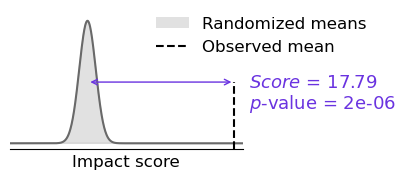

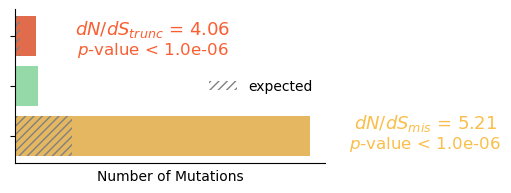

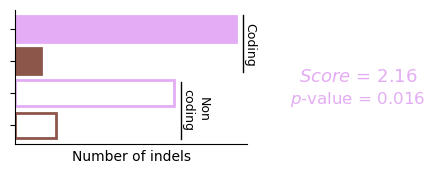

In [26]:
generate_all_side_figures("all_samples", deepcsa_run_dir,
                          gene_list = ['TP53'],
                          store_plots_dir = f"{plots_dir}",
                          tools = ["oncodrivefml", "oncodrive3d", "omega_trunc", "omega_mis", "excess_indels"]
                         )

In [27]:
# generate_all_side_figures("all_samples", deepcsa_run_dir,
#                           gene_list = ['TP53', "RBM10", "FGFR3"],
#                           store_plots_dir = f"{plots_dir}",
#                           tools = ["excess_indels"]
#                          )

In [ ]:
from scipy.stats import lognorm
from matplotlib.lines import Line2D


def get_toy_sim_vector(sim_vec, scale=0.002):
    
    shape, loc, _ = lognorm.fit(sim_vec, floc=0)
    toy_vec = lognorm.rvs(shape, loc, scale, size=(1, 10000)).flatten()
    
    return toy_vec


def plot_o3d_side_plot(sim_score_vec,
                       observed_score,
                       o3d_top_pos_score_gene,
                       pvalue,
                       scale=0.017,
                       figsize=(3, 1.75),
                       label_fontsize=12,
                       legend_fontsize=12,
                       text_fontsize=12,
                       background_color_fill="darkgray",
                       background_color_line="dimgrey",
                       observed_color="#3b99aa",
                       output_path=None):
    
    
    toy_sim_vec = get_toy_sim_vector(sim_score_vec, scale=0.017)

    fig, ax = plt.subplots(figsize=figsize)

    # Plot DKE and extract data
    kde = sns.kdeplot(x=toy_sim_vec, ax=ax, color=background_color_fill, linewidth=0.1)
    x, y = kde.get_lines()[0].get_data()

    # Plot the fill and extended line
    x_min, x_max = 0, 0.075
    x_extended = np.concatenate(([x_min - (x_max - x_min) * 0.05], x, [x_max + (x_max - x_min) * 0.05]))
    y_extended = np.concatenate(([0], y, [0]))
    ax.fill_betweenx(y, x, color = background_color_fill, alpha=0.2, label="Randomized mut densities")
    ax.plot(x_extended, y_extended, color=background_color_line)
    ax.vlines(observed_score, ymin=0, ymax=max(y)/2, color="black", zorder=1, linestyle='--', label="Observed mut density")

    # Details
    ax.set_ylim(-0.05 * max(y), max(y) * 1.05)
    ax.set_xlim(0.0005, x_max)
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.yaxis.set_visible(False)
    plt.ylabel(None)
    plt.xlabel("Clustering score", fontsize=label_fontsize)

    for spine in ['left', 'right', 'top']:
        ax.spines[spine].set_visible(False)

    # Arrow
    arrow_props = dict(facecolor= observed_color, edgecolor = observed_color, arrowstyle='<->')
    ax.annotate('', xy=(np.mean(toy_sim_vec), max(y)/2), xytext=(observed_score, max(y)/2), arrowprops=arrow_props)

    # Legend
    legend_handles = [Patch(facecolor=background_color_line, alpha=0.2, edgecolor='none', label='Randomized mut densities'),
                      Line2D([0], [0], color="black", linestyle='--', label='Observed mut density')]
    legend = ax.legend(handles=legend_handles, frameon=False, loc='upper right', bbox_to_anchor=(1.677, 1.1), fontsize=legend_fontsize)

    # Adjust the color of the text labels in the legend
    for text, color in zip(legend.get_texts(), ["black", "black"]):
        text.set_color(color)

    text = fr'$\mathit{{Score}} = {np.round(o3d_top_pos_score_gene, 2)}$'
    ax.text(observed_score*1.1, max(y)/2, text, ha='left', va='center', fontsize=text_fontsize+1, color=observed_color)
    pvalue = "{:.0e}".format(pvalue)
    ax.text(observed_score*1.1, max(y)/2 - 0.35*(max(y)/2), fr'$\mathit{{p}}$-value < {pvalue}', ha='left', va='center', 
            fontsize=text_fontsize+1, color=observed_color)

    if output_path is not None:
        print(f"Saving {output_path}")
        plt.savefig(output_path, bbox_inches='tight')
        
    plt.show()
    
o3d_temp_data = "/home/spellegrini/TEMP_DATA"
sim_score = pd.read_csv(f"{o3d_temp_data}/TP53_simulated_scores.csv")
sim_score = sim_score.drop(columns=["index"])[:1].values[0]

plot_o3d_side_plot(sim_score,
                   o3d_top_score_gene,
                   o3d_top_pos_score_gene,
                   o3d_pvalue,
                   scale=0.017,
                   figsize=(3, 1.75),
                   label_fontsize=12,
                   legend_fontsize=12,
                   text_fontsize=12,
                   output_path=f"{plots_dir}/side_plot_toy_tp53.png")

# __Manual side figures__

In [35]:
omega_file = f"{deepcsa_run_dir}/omega/output_mle.all_samples.tsv"
omega_data = pd.read_table(omega_file)
omega_data = omega_data[omega_data["impact"].isin(['missense', 'truncating'])]
omega_data = omega_data[omega_data["gene"].isin(gene_order)].reset_index(drop = True)
omega_data.head(10)

,gene,sample,impact,mutations,dnds,pvalue,lower,upper
0,CREBBP,all_samples,missense,1630,2.786035,0.0,2.555603,3.038110
1,CREBBP,all_samples,truncating,400,5.152344,0.0,4.436107,5.979370
2,ARID1A,all_samples,missense,1234,1.528125,0.0,1.393955,1.676440
3,ARID1A,all_samples,truncating,1850,15.885156,0.0,14.205010,17.779688
4,CDKN1A,all_samples,missense,239,2.403125,0.0,2.054907,2.803516
5,CDKN1A,all_samples,truncating,193,14.077344,0.0,11.638054,16.976514
6,KMT2C,all_samples,missense,564,1.416797,0.0,1.264989,1.586475
7,KMT2C,all_samples,truncating,163,2.973047,0.0,2.401561,3.664575
8,TP53,all_samples,missense,559,5.210742,0.0,4.648260,5.833911
9,TP53,all_samples,truncating,68,4.061719,0.0,3.082421,5.275708


In [36]:
omega_truncating = omega_data[omega_data["impact"] == "truncating"].reset_index(drop = True)[["gene", "dnds", "pvalue", "lower", "upper"]]
omega_truncating.columns = ["GENE", "omega_trunc", "pvalue", "lower", "upper"]

omega_missense = omega_data[omega_data["impact"] == "missense"].reset_index(drop = True)[["gene", "dnds", "pvalue", "lower", "upper"]]
omega_missense.columns = ["GENE", "omega_mis", "pvalue", "lower", "upper"]

omega_missense

,GENE,omega_mis,pvalue,lower,upper
0,CREBBP,2.786035,0.000000,2.555603,3.038110
1,ARID1A,1.528125,0.000000,1.393955,1.676440
2,CDKN1A,2.403125,0.000000,2.054907,2.803516
3,KMT2C,1.416797,0.000000,1.264989,1.586475
4,TP53,5.210742,0.000000,4.648260,5.833911
5,RBM10,3.303516,0.000000,2.990728,3.648364
6,TERT,1.557617,0.318330,0.613027,3.209839
7,NOTCH2,2.533594,0.000000,2.319187,2.769189
8,STAG2,1.763257,0.000000,1.577487,1.969556
9,RB1,1.718750,0.000000,1.473451,1.997681


In [37]:
genee = 'TP53'

trunc_omega = float(omega_truncating[omega_truncating["GENE"] == genee]["omega_trunc"].values[0])
trunc_pvalue = float(omega_truncating[omega_truncating["GENE"] == genee]["pvalue"].values[0])

miss_omega = float(omega_missense[omega_missense["GENE"] == genee]["omega_mis"].values[0])
miss_pvalue = float(omega_missense[omega_missense["GENE"] == genee]["pvalue"].values[0])
snvs_maf_gene = snvs_maf[snvs_maf["SYMBOL"] == genee].reset_index(drop = True)

print(trunc_omega, miss_omega)
snvs_maf_gene.head()

4.061718750000006 5.210742187500009


,CHROM,POS,REF,ALT,FILTER,INFO,FORMAT,SAMPLE,DEPTH,ALT_DEPTH,REF_DEPTH,VAF,vd_DEPTH,vd_ALT_DEPTH,vd_REF_DEPTH,vd_VAF,numNs,VAF_Ns,DEPTH_AM,ALT_DEPTH_AM,REF_DEPTH_AM,VAF_AM,numNs_AM,VAF_Ns_AM,DEPTH_ND,ALT_DEPTH_ND,VAF_ND,VAF_distorted_expanded,VAF_distorted_expanded_sq,VAF_distortion,VAF_distortion_sq,MUT_ID,SAMPLE_ID,METHOD,PROJECT_NAME,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT,DISTANCE,STRAND,FLAGS,SYMBOL,SYMBOL_SOURCE,HGNC_ID,CANONICAL,ENSP,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,CLIN_SIG,SOMATIC,PHENO,canonical_Location,canonical_Allele,canonical_Gene,canonical_Feature,canonical_Feature_type,canonical_Consequence,canonical_cDNA_position,canonical_CDS_position,canonical_Protein_position,canonical_Amino_acids,canonical_Codons,canonical_IMPACT,canonical_DISTANCE,canonical_STRAND,canonical_FLAGS,canonical_SYMBOL,canonical_SYMBOL_SOURCE,canonical_HGNC_ID,canonical_CANONICAL,canonical_ENSP,canonical_CLIN_SIG,canonical_Consequence_single,canonical_Consequence_broader,canonical_Protein_affecting,Consequence_single,Consequence_broader,Protein_affecting,CONTEXT_MUT,MUTTYPE,CONTEXT_MUT_SIGPRO,gnomAD_SNP,HOTSPOT_NAME,MUT_ID_pyr,CHROM_ensembl,POS_ensembl,REF_ensembl,ALT_ensembl,TYPE,INDEL_LENGTH,INDEL_INFRAME,INDEL_MULTIPLE3,N_rich_frequency,VAF_Ns_threshold,FILTER.cohort_n_rich_uni,FILTER.gnomAD_SNP,FILTER.not_covered,FILTER.not_in_exons,FILTER.p10,FILTER.pSTD,FILTER.repetitive_variant,FILTER.cohort_n_rich,FILTER.low_complex_repetitive,FILTER.LongMSI,FILTER.cohort_n_rich_threshold,FILTER.AM_no_pileup_support,FILTER.no_pileup_support,FILTER.n_rich,FILTER.other_sample_SNP,FILTER.PASS,FILTER.AM_not_searched_COMPLEX,FILTER.not_searched_COMPLEX,FILTER.MSI12,FILTER.AM_not_searched_SV,FILTER.not_searched_SV,FILTER.SN1.5,FILTER.q22.5,FILTER.v1,FILTER.low_mappability,FILTER.Bias,FILTER.d3
0,chr17,7669609,T,G,pSTD,SAMPLE=P19_0050_BTR_01;TYPE=SNV;DP=11039;VD=1;...,GT:DP:VD:AD:AF:RD:ALD:CDP:CAD:NDP:CDPAM:CADAM:...,"0/1:11039:1:11038,1:0.0001:5731,5307:0,1:11039...",11039,1,11038,0.000091,11039,1,11038,0.000091,39,0.003520,26456,1,26453,0.000038,69,0.002601,15417,0,0.000000,False,False,0.417259,0.914168,chr17:7669609_T>G,P19_0050_BTR_01,med,NaN,chr17:7669609,G,ENSG00000141510,ENST00000269305,Transcript,stop_lost,1324,1182,394,*/C,tgA/tgC,"rs1555524074,COSV53447276",HIGH,-,-1,-,TP53,HGNC,HGNC:11998,YES,ENSP00000269305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-,"0,1","1,1",chr17:7669609,G,ENSG00000141510,ENST00000269305,Transcript,stop_lost,1324,1182,394,*/C,tgA/tgC,HIGH,-,-1.0,-,TP53,HGNC,HGNC:11998,YES,ENSP00000269305,-,stop_lost,nonsense,protein_affecting,stop_lost,nonsense,protein_affecting,GTC>G,T>G,G[T>G]C,False,-,chr17:7669609_T>G,17,7669609,T,G,SNV,0,False,False,0.0,1.1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,chr17,7669610,C,A,pSTD,SAMPLE=P19_0009_BTR_01;TYPE=SNV;DP=4778;VD=1;A...,GT:DP:VD:AD:AF:RD:ALD:CDP:CAD:NDP:CDPAM:CADAM:...,"0/1:4778:1:4777,1:0.0002:3807,970:1,0:4778:477...",4778,1,4777,0.000209,4778,1,4777,0.000209,24,0.004998,10062,1,10061,0.000099,41,0.004058,5284,0,0.000000,False,False,0.474856,0.919195,chr17:7669610_C>A,P19_0009_BTR_01,med,NaN,chr17:7669610,A,ENSG00000141510,ENST00000269305,Transcript,stop_lost,1323,1181,394,*/L,tGa/tTa,"rs2150987942,COSV106372478",HIGH,-,-1,-,TP53,HGNC,HGNC:11998,YES,ENSP00000269305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-,"0,1","0,1",chr17:7669610,A,ENSG00000141510,ENST00000269305,Transcript,stop_lost,1323,1181,394,*/L,tGa/tTa,HIGH,-,-1.0,-,TP53,HGNC,

Observed

In [38]:
# "#ef476f","#f78c6b","#ffd166","#06d6a0","#118ab2","#073b4c"

# Define colors for each type
# colors = {
#     'counts_truncating': '#ef476f',
#     'counts_missense': '#f78c6b',
#     'counts_synonymous': '#06d6a0'
# }


In [39]:
def plot_omega_side(df):

    consequence_order = ['truncating', "synonymous", "missense"]

    # Define colors for each type
    colors = {
        'truncating': metrics_colors_dictionary["omega_trunc"],
        'missense': metrics_colors_dictionary["omega_miss"],
        'synonymous': metrics_colors_dictionary["omega_synon"]
    }

    # Plot for truncating, missense, and synonymous
    fig = plt.figure(figsize=(3, 2))

    # Plot the observed values as filled bars
    sns.barplot(data=df, y='type', x='number_obs',
                hue = 'type', legend = False,
                hue_order = consequence_order,
                order=consequence_order, palette=[colors[x] for x in consequence_order])

    # Overlay the expected values with shaded portions
    leg = True
    for i, row in df.iterrows():
        if row['expected'] is not None:
            # plt.barh(row['type'], row['expected'], color='gray', alpha=0.5, edgecolor='none')
            # plt.barh(row['type'], row['expected'], color='none', edgecolor=colors[row['type']], hatch='//', linewidth=0)
            if leg:
                plt.barh(row['type'], row['expected'], color='none', edgecolor="gray", hatch='////', linewidth=0, label = 'expected')
                leg = False
            else:
                plt.barh(row['type'], row['expected'], color='none', edgecolor="gray", hatch='////', linewidth=0)



    # Remove the right and top spines
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Customize the ticks and labels
    ax.xaxis.set_ticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])


    # Text annotations
    text_separation = max(df['number_obs']) * 0.03
    deviation_for_centering = text_separation * 12
    
    # text_of_line_separation = line_separation / 3
    text_pos1 = max(df[df['type'].isin(consequence_order[:2])]['number_obs']) + text_separation + deviation_for_centering
    text_pos2 = max(df[df['type'].isin(consequence_order[1:])]['number_obs']) + text_separation + deviation_for_centering
    # print(text_pos1, text_pos2)
    
    ax.text(text_pos1, 0.05, r'$\omega_{trunc}$ = ' + f"{trunc_omega:.2f}",
            # transform=ax.transAxes,
            fontsize=13, ha='center', va='bottom',
            color=colors['truncating'])
                   #f'$p$-value = {p_value:.2g}')

    ax.text(text_pos1, 0.45, f'$p$-value < {max(trunc_pvalue, 1e-6):.1e}',
            # transform=ax.transAxes,
            fontsize=12, ha='center', va='bottom',
            color=colors['truncating'])

    ax.text(text_pos2, 1.95, r'$\omega_{mis}$ = ' + f"{miss_omega:.2f}",
            # transform=ax.transAxes,
            fontsize=13, ha='center', va='bottom',
            color=colors['missense'])
    ax.text(text_pos2, 2.35, f'$p$-value < {max(miss_pvalue, 1e-6):.1e}',
            # transform=ax.transAxes,
            fontsize=12, ha='center', va='bottom',
            color=colors['missense'])

    # Update labels
    plt.xlabel('Number of Mutations')
    # plt.xscale('log')
    plt.ylabel('')
    plt.legend(loc='right', frameon=False)
    # plt.legend(loc='right', frameon=False, fontsize=12, handlelength=3, markerscale=2)  # Increase legend text and marker size
    # plt.show()
    return fig


In [42]:
help(build_counts_from_df_complete)

Help on function build_counts_from_df_complete in module __main__:

build_counts_from_df_complete(genee, snvs_maf, omega_truncating, omega_missense)



In [41]:
for genee in ['TP53']:
# for genee in gene_order:

    trunc_omega = float(omega_truncating[omega_truncating["GENE"] == genee]["omega_trunc"].values[0])
    trunc_pvalue = float(omega_truncating[omega_truncating["GENE"] == genee]["pvalue"].values[0])

    miss_omega = float(omega_missense[omega_missense["GENE"] == genee]["omega_mis"].values[0])
    miss_pvalue = float(omega_missense[omega_missense["GENE"] == genee]["pvalue"].values[0])
    snvs_maf_gene = snvs_maf[snvs_maf["SYMBOL"] == genee].reset_index(drop = True)
    
    print(trunc_omega, miss_omega)

    df_counts = build_counts_from_df_complete(snvs_maf_gene)

    fig_gene = plot_omega_side(df_counts)
    # fig_gene.savefig(f"Fig3/plots/omega_side/{genee}.omega_side.pdf", bbox_inches='tight')
    print(genee)
    plt.show()

4.061718750000006 5.210742187500009


TypeError: build_counts_from_df_complete() missing 3 required positional arguments: 'snvs_maf', 'omega_truncating', and 'omega_missense'

## Excess truncating indels

In [28]:
all_indels = pd.read_table(f"{deepcsa_run_dir}/indels/all_samples.sample.indels.tsv",
                           sep = '\t',
                           header = 0)
all_indels_without = all_indels[all_indels["SYMBOL"] != "ALL_GENES"].reset_index(drop = True)
all_indels

,SYMBOL,NOT_MULTIPLE_3.non_protein_affecting,MULTIPLE_3.non_protein_affecting,TRUNCATING.protein_affecting,NON_TRUNCATING.protein_affecting,Npa_NM3/M3,pa_TRUNC/NOTTRUNC,pa/Npa,g_test_score,pvalue
0,-,1,0,0,0,inf,-1.000000,1.000000,0.000000,1.000000e+00
1,ARID1A,103,43,2249,91,2.395349,24.714286,10.317614,1022.352756,2.486770e-224
2,BAGE2,17,3,0,0,5.666667,-1.000000,1.000000,0.000000,1.000000e+00
3,BMP2K,0,0,0,4,-1.000000,0.000000,1.000000,NaN,NaN
4,CDKN1A,27,6,606,27,4.500000,22.444444,4.987654,112.087459,3.418907e-26
5,CREBBP,162,34,460,113,4.764706,4.070796,0.854365,2.176278,1.401530e-01
6,EP300,156,35,661,145,4.457143,4.558621,1.022767,0.060555,8.056205e-01
7,FGFR1,0,0,1,0,-1.000000,inf,1.000000,NaN,NaN
8,FGFR3,22,1,19,9,22.000000,2.111111,0.095960,22.963334,1.651209e-06
9,FGFR4,0,0,0,1,-1.000000,0.000000,1.000000,NaN,NaN


#### Plotting

In [29]:
def plotting_indels_side(data_gene):

    # Bar labels and values
    labels = ['MULTIPLE_3.non_protein_affecting', 'NOT_MULTIPLE_3.non_protein_affecting',
              'NON_TRUNCATING.protein_affecting', 'TRUNCATING.protein_affecting']
    values = [ data_gene[x] for x in labels ]

    # Colors:
    truncating_indels_color = metrics_colors_dictionary["frameshift"]
    nontruncating_color = metrics_colors_dictionary["inframe"]
    colors = ['none', 'none', nontruncating_color, truncating_indels_color]
    edgecolors = [nontruncating_color, truncating_indels_color, nontruncating_color, truncating_indels_color]

    # Create the plot with a smaller height
    fig, ax = plt.subplots(figsize=(3, 1.75))  # Adjust the height and width

    # Plot the bars horizontally with the specified colors and hatches
    bars = ax.barh(labels, values, color=colors, edgecolor=edgecolors, linewidth = 2)

    # Remove the right and top spines
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


    max_syn = max(values) * 1.55

    # Vertical lines
    line_separation = max(values) * 0.03
    text_of_line_separation = line_separation # / 2
    line_pos1 = max(values[:2]) + line_separation
    line_pos2 = max(values[2:]) + line_separation
    line_margin = 0.04
    ax.axvline(x=line_pos1, ymin = line_margin, ymax = 0.5 - line_margin, color='black',
               # linestyle='--',
               linewidth=1)
    ax.axvline(x=line_pos2, ymin = 0.5 + line_margin, ymax = 1 - line_margin, color='black',
               # linestyle='--',
               linewidth=1)

    # Annotation for "PA" and "NPA" next to vertical lines
    ax.text(line_pos1 + 2.2*text_of_line_separation, 0.5, 'Non\ncoding', ha='center', va='center', fontsize=9,
            rotation = 270
            # bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5)
           )
    ax.text(line_pos2 + text_of_line_separation, 2.5, 'Coding', ha='center', va='center', fontsize=9,
            rotation = 270
            # bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5)
           )


    # # Arrows with annotations
    # arrow_props = dict(facecolor='black', arrowstyle='<-')

    # # Arrow 1
    # ax.annotate('', xy=(line_pos1 + 15, 0.5), xytext=(max_syn/1.25, 1.2),
    #             arrowprops=arrow_props)

    # # Arrow 2
    # ax.annotate('', xy=(line_pos2, 2.5), xytext=(max_syn, 1.75),
    #             arrowprops=arrow_props)

    formula_ratio = (f'$\\frac{{{data_gene["pa_TRUNC/NOTTRUNC"]:.2f}}}{{{data_gene["Npa_NM3/M3"]:.2f}}} = {data_gene["pa/Npa"]:.2f}$')
    ax.text(max_syn, 1.5, formula_ratio,
        fontsize=14, ha='center', va='center',
       )

    pvalue_tag = f'$p$-value = {data_gene["pvalue"]:.2g}'
    ax.text(max_syn, 0.6, pvalue_tag,
        fontsize=12, ha='center', va='center',
       )

    # Add title and labels
    ax.set_xlabel('Count')

    # Customize the ticks and labels
    ax.xaxis.set_ticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Update labels
    plt.xlabel('Number of indels')
    plt.ylabel('')

    # plt.tight_layout()

    # plt.show()
    
    return fig


TP53


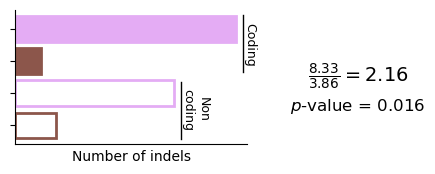

FGFR3


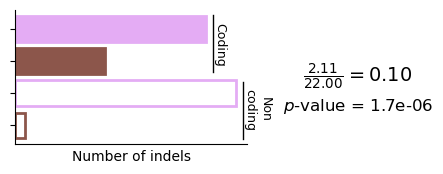

RBM10


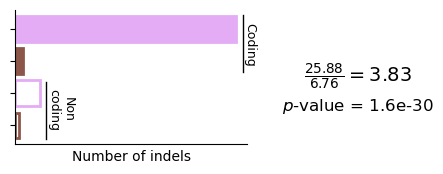

In [30]:
for genee in ['TP53', 'FGFR3', 'RBM10']:
# for genee in gene_order:

    data_genee = all_indels[all_indels["SYMBOL"] == genee].to_dict(orient='records')[0]
    print(genee)
    
    fig_gene = plotting_indels_side(data_genee)
    fig_gene.savefig(f"{plots_dir}/{genee}.indels_side.v2.png", bbox_inches='tight')
    plt.show()
    plt.close()

# Exploration

## OncodriveFML side figure

In [39]:
oncodrivefml_file = f"{deepcsa_run_dir}/oncodrivefmlsnvs/all_samples.all/all_samples-oncodrivefml.tsv.gz"
oncodrivefml_data = pd.read_table(oncodrivefml_file)
# oncodrivefml_data.head(10)
oncodrivefml_data.loc[oncodrivefml_data["Z-SCORE"] < 0, "Q_VALUE"] = oncodrivefml_data[oncodrivefml_data["Z-SCORE"] < 0]["Q_VALUE_NEG"]
oncodrivefml_data = oncodrivefml_data[["GENE_ID", "Z-SCORE", "Q_VALUE", "AVG_SCORE_OBS", "POPULATION_MEAN", "STD_OF_MEANS"]]
oncodrivefml_data.columns = ["GENE", "OncodriveFML", "pvalue", "OBSERVED_MEAN", "BACKGROUND_MEAN", "BACKGROUND_STD"]
oncodrivefml_data = oncodrivefml_data[oncodrivefml_data["GENE"].isin(gene_order)].reset_index(drop = True)
oncodrivefml_data

,GENE,OncodriveFML,pvalue,OBSERVED_MEAN,BACKGROUND_MEAN,BACKGROUND_STD
0,KMT2D,108.47620,0.000002,28.332420,17.822863,0.096884
1,CDKN1A,17.08819,0.000002,25.530964,17.411876,0.475129
2,FOXQ1,13.52358,0.000002,22.402516,17.320651,0.375778
3,TP53,20.49542,0.000002,23.624952,16.020699,0.371022
4,STAG2,33.35271,0.000002,28.745690,21.394586,0.220405
5,NOTCH2,19.70318,0.000002,24.152305,19.577342,0.232194
6,KMT2C,8.28171,0.000002,20.612043,17.640192,0.358845
7,EP300,25.60463,0.000002,25.462695,20.537196,0.192368
8,KDM6A,57.29525,0.000002,30.046206,20.265489,0.170707
9,RBM10,56.32502,0.000002,30.050550,19.485481,0.187573


In [44]:
# for genee in ['ARID1A']:
for genee in gene_order:
    # Select the specific gene data
    oncodrivefml_gene_data = oncodrivefml_data[oncodrivefml_data["GENE"] == genee].to_dict(orient='records')
    if len(oncodrivefml_gene_data) > 0:
        fig_gene_fml = plot_oncodrivefml_side(oncodrivefml_gene_data[0])
        fig_gene_fml.savefig(f"plot/side/{genee}.oncodrivefml_side.v2.png", bbox_inches='tight')
        print(genee)
        plt.show()

## OMEGA side plot

## OncodriveFML
All possible scores per position

In [ ]:
# for gene in ["TP53"]:
for gene in gene_order:
    gene_info = seq_regions_df[seq_regions_df["Gene"] == gene]
    scores_all_mutations_in_gene, scores_of_protein_position = get_scores_gene(gene_info)
    
    mutations_in_gene = snvs_maf[snvs_maf["canonical_SYMBOL"] == gene].copy()
    scored_mutations_in_gene = score_mutations_from_gene(mutations_in_gene)
    
    scored_mutations_in_gene.to_csv(f"{data_dir}/mutations_scored.{gene}.tsv", sep = '\t', header= True, index = False)

In [23]:
muts_per_position_in_gene = mutations_in_gene.groupby(by = "canonical_CDS_position").agg( { "MUT_ID" : 'count',
                                                                                           "CADDscore" : 'mean'}).reset_index()
muts_per_position_in_gene

,canonical_CDS_position,MUT_ID,CADDscore
0,6,1,5.515000
1,9,1,0.514000
2,15,3,2.983333
3,16,1,15.030000
4,19,1,23.300000
...,...,...,...
360,1164,1,3.941000
361,1171,2,25.500000
362,1174,1,26.700000
363,1177,1,24.900000


In [24]:
df_all_scores = pd.DataFrame(scores_all_mutations_in_gene).fillna(0).values
df_all_scores

array([[16.43 ,  4.484, 23.2  , ..., 17.12 , 14.39 , 15.86 ],
       [23.9  ,  4.556, 18.16 , ..., 17.26 , 19.2  , 23.1  ],
       [24.1  ,  0.   ,  0.   , ...,  0.   , 17.55 , 23.1  ],
       [ 0.   ,  4.774, 20.5  , ..., 19.98 ,  0.   ,  0.   ]])

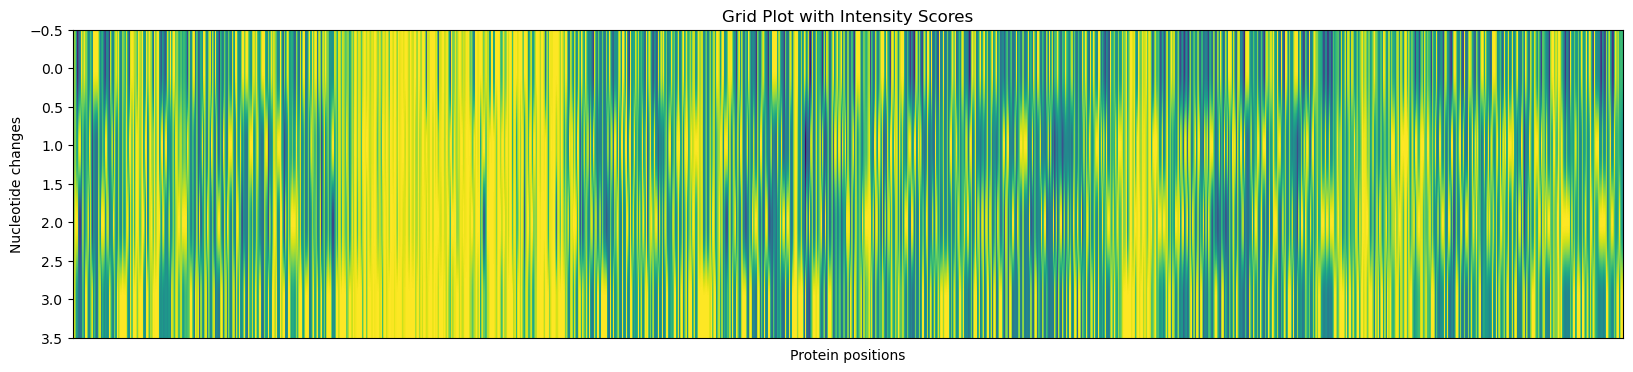

In [25]:
import matplotlib.pyplot as plt
import numpy as np

scores = df_all_scores

fig, ax = plt.subplots(figsize=(20, 4))  # Adjust the figure size as needed

# Plot the grid using imshow
cax = ax.imshow(scores, aspect='auto', cmap='viridis_r')

# # Add a colorbar to show the intensity scale
# cbar = fig.colorbar(cax, orientation='vertical')
# cbar.set_label('Intensity')

# Set axis labels
ax.set_xlabel('Protein positions')
ax.set_ylabel('Nucleotide changes')

# Set title
ax.set_title('Grid Plot with Intensity Scores')

# Remove the ticks
ax.set_xticks([])
# ax.set_yticks([])

# Display the plot
plt.show()


#### Indels

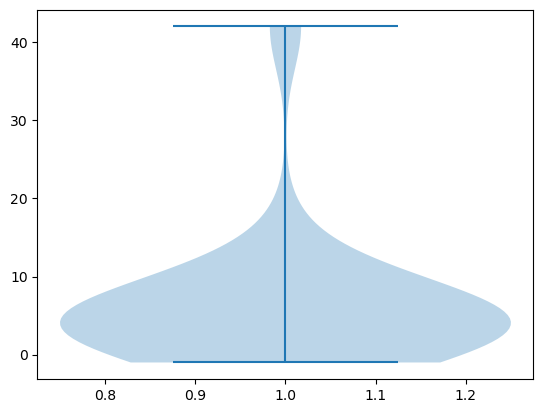

In [472]:
plt.violinplot(all_indels_without[all_indels_without["Npa_NM3/M3"] != np.inf]["Npa_NM3/M3"])
plt.show()

In [461]:
all_indels[all_indels["SYMBOL"] == "ALL_GENES"]["Npa_NM3/M3"]

105    7.350508
Name: Npa_FSH/INF, dtype: float64

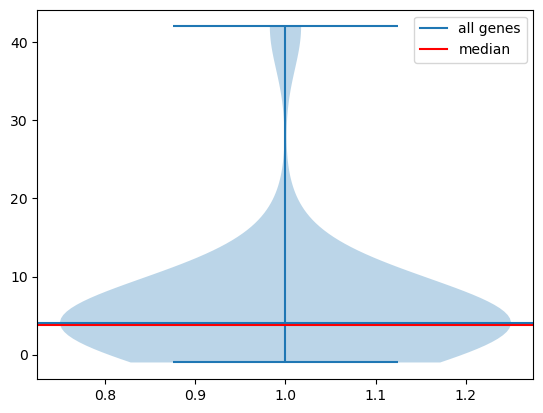

In [473]:
plt.violinplot(all_indels_without[all_indels_without["Npa_NM3/M3"] != np.inf]["Npa_NM3/M3"])
plt.axhline(y = all_indels[all_indels["SYMBOL"] == "ALL_GENES"]["Npa_NM3/M3"].item(), label = 'all genes')
plt.axhline(y = all_indels_without[all_indels_without["Npa_NM3/M3"] != np.inf]["Npa_NM3/M3"].median(), label = 'median', color = 'r')
plt.legend()
plt.show()

In [476]:
all_indels_without[all_indels_without["Npa_NM3/M3"] != np.inf].sort_values(by = ["pa_TRUNC/NOTTRUNC"], ascending = False).head(20)

,SYMBOL,NOT_MULTIPLE_3.non_protein_affecting,MULTIPLE_3.non_protein_affecting,TRUNCATING.protein_affecting,NON_TRUNCATING.protein_affecting,Npa_NM3/M3,pa_TRUNC/NOTTRUNC,pa/Npa,g_test_score,pvalue
15,TERT,10,2,2,0,5.000000,inf,inf,0.729286,3.931146e-01
13,RBM10,161,22,1461,52,7.318182,28.096154,3.839226,141.838117,1.055062e-32
9,KMT2D,252,49,5716,241,5.142857,23.717842,4.611803,888.078019,3.832969e-195
7,KDM6A,112,31,2653,113,3.612903,23.477876,6.498341,698.005020,8.119450e-154
1,CDKN1A,30,6,819,35,5.000000,23.400000,4.680000,131.899488,1.573897e-30
0,ARID1A,110,39,2428,114,2.820513,21.298246,7.551196,848.601180,1.464445e-186
14,STAG2,97,27,992,58,3.592593,17.103448,4.760754,215.364233,9.281336e-49
6,FOXQ1,55,4,826,62,13.750000,13.322581,0.968915,0.056992,8.113156e-01
16,TP53,66,19,108,13,3.473684,8.307692,2.391608,11.048483,8.875981e-04
10,NOTCH2,124,47,530,79,2.638298,6.708861,2.542875,74.752169,5.336712e-18
